In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.model_selection import StratifiedKFold
from scipy import interp
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import time
from collections import Counter
from sklearn.metrics import precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [ ]:
#Reading features extracted by the DenseNet model
df = pd.DataFrame()

i = 0
for chunk in pd.read_csv('/content/dense_CC.csv', header=None, chunksize=1000, dtype=float):
    df = pd.concat([df, chunk], ignore_index=False)
    #print(i)
    i = i + 1000

print(df.shape)

(172032, 2049)


In [ ]:
#Preparing holdout set
sampleCount= 1500
holdout_pos = df[df[0]==1].sample(n=sampleCount, random_state=42)
#print(holdout_pos.head())
df = df.drop(holdout_pos.index)

sampleCount= 1500
holdout_neg = df[df[0]==0].sample(n=sampleCount, random_state=42)
df = df.drop(holdout_neg.index)

holdout = pd.concat([holdout_pos, holdout_neg])

print(df.shape)
print(holdout.shape)

(169032, 2049)
(3000, 2049)


In [ ]:
X_test = holdout.iloc[:, 1:].values
y_test = holdout[0].values
print(Counter(y_test))

X_test = preprocessing.MinMaxScaler().fit_transform(X_test)

Counter({1.0: 1500, 0.0: 1500})


In [ ]:
negCount = 10000
#Preparing train set
posSet = df[df[0]==1]
print(posSet.shape)
##############
from sklearn.utils import resample
# upsample minority
posSet = resample(posSet,
                          replace=True, # sample with replacement
                          n_samples=10000, # match number in majority class
                          random_state=42) # reproducible results
##############################
negSet= df[df[0]==0].sample(n=negCount, random_state=42)
print(negSet.shape)

dfTrain = pd.concat([posSet,negSet])
print(dfTrain.shape)

(4536, 2049)
(10000, 2049)
(20000, 2049)


In [ ]:
X_train = dfTrain.iloc[:, 1:].values
y_train = dfTrain[0].values
print(Counter(y_train))

#Scaling features
X_train= preprocessing.MinMaxScaler().fit_transform(X_train)

Counter({1.0: 10000, 0.0: 10000})


In [ ]:
#balancing dataset
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)
print(X_train.shape)

In [ ]:
nEpochs = 10
nBatch= 32
inputDim = X_train.shape[1] # Count of features

In [ ]:
model = Sequential()
model.add(Dense(256, input_dim=inputDim, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))


#model.summary()

In [ ]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

# Fiting the model 
model.fit(X_train, y_train,
          validation_split=0.2, 
          epochs=nEpochs, 
          batch_size=nBatch,
          verbose=1)

Train on 16000 samples, validate on 4000 samples
Epoch 1/10
16000/16000 [==============================] - 7s 449us/step - loss: 0.6227 - acc: 0.6711 - val_loss: 0.7925 - val_acc: 0.4517
Epoch 2/10
16000/16000 [==============================] - 5s 290us/step - loss: 0.5942 - acc: 0.6950 - val_loss: 1.0111 - val_acc: 0.4400
Epoch 3/10
16000/16000 [==============================] - 5s 289us/step - loss: 0.5782 - acc: 0.7117 - val_loss: 0.8590 - val_acc: 0.4970
Epoch 4/10
16000/16000 [==============================] - 5s 288us/step - loss: 0.5663 - acc: 0.7176 - val_loss: 0.9024 - val_acc: 0.4893
Epoch 5/10
16000/16000 [==============================] - 5s 290us/step - loss: 0.5596 - acc: 0.7240 - val_loss: 0.9998 - val_acc: 0.4627
Epoch 6/10
16000/16000 [==============================] - 5s 290us/step - loss: 0.5554 - acc: 0.7223 - val_loss: 0.6436 - val_acc: 0.6105
Epoch 7/10
16000/16000 [==============================] - 5s 288us/step - loss: 0.5481 - acc: 0.7301 - val_loss: 0.7855 - v

In [ ]:
model.evaluate(x=X_test, y=y_test, verbose=1)

3000/3000 [==============================] - 0s 84us/step


[0.6362204546928406, 0.6756666666666666]

In [ ]:
predictions =model.predict(X_test)

In [ ]:
AUC = roc_auc_score(y_test, model.predict(X_test))
print(AUC)

0.7460977777777777


In [ ]:
#The recall is intuitively the ability of the classifier to find all the positive samples
print("Recall:", recall_score(y_test, predictions.round()))

Recall: 0.828


In [ ]:
print("Precision:", precision_score(y_test, predictions.round()))

Precision: 0.6346448645886561


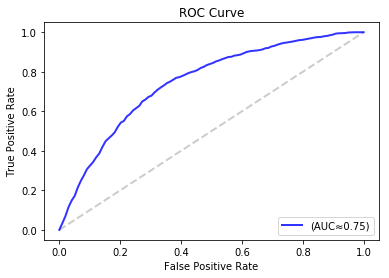

In [ ]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
 
fpr, tpr, thresholds = roc_curve(y_test, predictions)

tprs.append(interp(mean_fpr, fpr, tpr))
tprs[-1][0] = 0.0

# Drawing line from origin represnting random predictions
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black',alpha=0.2)

#Adding to ROC plot
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'(AUC≈%0.2f)' % (mean_auc),
         lw=2, alpha=0.8)


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC Curve')
plt.show()
